In [10]:
import pyaudio
import wave
import sys

import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np

from pydub import AudioSegment

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
def record(filename, time_s, rate=44100):

    chunk = 1024
    audio = pyaudio.PyAudio()

    # start recording
    stream = audio.open(format=pyaudio.paInt16,
                        channels=2,
                        rate=rate,
                        input=True,
                        frames_per_buffer=chunk)

    print("recording...")
    frames = []
    secs = [int(rate*l/chunk) for l in range(time_s)]
    
    for i in range(int(rate/chunk * time_s)):
        if i in secs:
            print(time_s - secs.index(i))
        data = stream.read(chunk)
        frames.append(data)

    print("finished recording")

    # stop recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

    wave_file = wave.open(filename, 'wb')
    wave_file.setnchannels(2)
    wave_file.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
    wave_file.setframerate(rate)
    wave_file.writeframes(b''.join(frames))
    wave_file.close()

In [4]:
def play(filename):
    chunk = 1024

    wf = wave.open(filename, 'rb')

    # instantiate PyAudio
    p = pyaudio.PyAudio()

    # open stream
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    # read data
    data = wf.readframes(chunk)

    # play stream
    while len(data) > 0:
        stream.write(data)
        data = wf.readframes(chunk)

    # stop stream
    p.terminate()

In [27]:
def plot_spectrogram(filename):
    fs, x = wavfile.read(filename)
    f, t, sxx0 = signal.spectrogram(x[:,0], fs)
    f, t, sxx1 = signal.spectrogram(x[:,1], fs)

    plt.subplot(211)
    plt.pcolormesh(t, f, np.log10(sxx0))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.subplot(212)
    plt.pcolormesh(t, f, np.log10(sxx1))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
#     return t, f, sxx0, sxx1

In [21]:
filename = 'whale_stream.wav'

In [13]:
record(filename, 5, 44100)

recording...
5
4
3
2
1
finished recording


/Users/dave/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/dave/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


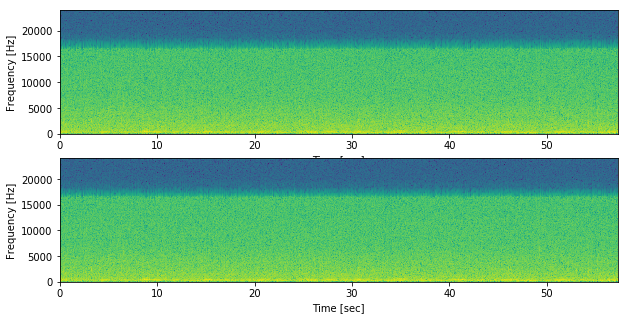

In [28]:
plot_spectrogram(filename)

In [23]:
play(filename)

In [20]:
from os import path

# files                                                                         
src = "whale_stream.mp3"
dst = "whale_stream.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='whale_stream.wav'>